In [1]:
import sys
import csv

# Command for Marijn:
sys.path.append('/Users/marijnvandermeer/opt/anaconda3/envs/env_pytorch/lib/python3.6/site-packages')


from torch import empty
from linear import Linear
from relu import ReLU
from leakyrelu import LeakyReLU
from generate_dataset import generate_set
from sequential import Sequential
from gd import GD
from tanh import Tanh
from sgd import SGD
from mse import MSE
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import torch
torch.set_grad_enabled(False)

In [2]:
import autoreload
%load_ext autoreload
%autoreload 2

## Generate data:

In [3]:
# ------------------------------------------------------------------
# Control the randomness
# ------------------------------------------------------------------
torch.manual_seed(0)

N = 1000
center = (0.5, 0.5)
r = 1 / (math.sqrt(2 * math.pi))
training_data, training_labels = generate_set(N, center, r)
test_data, test_labels = generate_set(N, center, r)

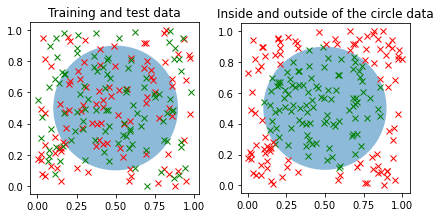

In [4]:
# test my function :) 
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
fig.tight_layout()

circle1 = plt.Circle(center, r, alpha = 0.5)
axs[0].set_title("Training and test data")
axs[0].set_aspect('equal')
axs[0].add_patch(circle1)
for point in training_data[:100]:
    axs[0].plot(point[0], point[1], 'x',color = 'r', label = 'training')
for point in test_data[:100]:
    axs[0].plot(point[0], point[1], 'x',color = 'g', label = 'test')

circle2 = plt.Circle(center, r, alpha = 0.5)
axs[1].set_title("Inside and outside of the circle data")
axs[1].set_aspect('equal')
axs[1].add_patch(circle2)
for point in training_data[training_labels.type(torch.BoolTensor)][:100]:
    axs[1].plot(point[0], point[1], 'x',color = 'g', label = 'training')
for point in training_data[~training_labels.type(torch.BoolTensor)][:100]:
    axs[1].plot(point[0], point[1], 'x',color = 'r', label = 'training')
    
plt.show()

## Set up model:

Builds a network with two input units, two output units, three hidden layers of 25 units

In [6]:
# ------------------------------------------------------------------
# Functions
# ------------------------------------------------------------------
def data_split(data, batch_size):
    batch = [data[i:i + batch_size] for i in range(0, len(data), batch_size)] 
    return batch

def data_normalize(data):
    normalized = (data - data.mean())/data.std()    
    return normalized

def threshold(x):
    if x > 0:
        return 1
    else:
        return 0

### Training: 

In [8]:
# ------------------------------------------------------------------
# Control the randomness
# ------------------------------------------------------------------
torch.manual_seed(0)

N = 1000
center = (0.5, 0.5)
r = 1 / (math.sqrt(2 * math.pi))

print('Generating test and training set')
training_data, training_labels = generate_set(N, center, r)
test_data, test_labels = generate_set(N, center, r)

print('Setting up model')
# ------------------------------------------------------------------
# Model
# ------------------------------------------------------------------
print('Model: linear(2,25), ReLu(), linear(25,25), tanh(), linear(25,25), tanh(), linear(25,25), tanh(), linear(25,1)')
m1 = Linear(2, 25)
m2 = Linear(25, 25)
m3 = Linear(25, 25)
m4 = Linear(25, 25)
m5 = Linear(25, 1)
r = ReLU()
tanh = Tanh()
# Sequential composition of model:
s = Sequential([m1, r,  m2, tanh, m4, tanh, m3, tanh, m5])
#print('Parameters of model:\n{}\n'.format(s.param()))
# Parameters:
batch_size = 4
num_epochs = 25
lr = 1e-3
gd = GD(s.param(), lr)
mse = MSE()

# Split data:
training_batches = data_split(data_normalize(training_data), batch_size)
tlabel_batches = data_split(training_labels, batch_size)

test_batches = data_split(data_normalize(test_data), batch_size)
testlabel_batches = data_split(test_labels, batch_size)

# ------------------------------------------------------------------
# Train
# ------------------------------------------------------------------

avg_loss = torch.empty(len(training_batches)*num_epochs)
avg_loss_test = torch.empty(len(training_batches)*num_epochs)

m = 0
print('Start training!')
for j in range(num_epochs):
    print('# Epoch:{}/{}'.format(j, num_epochs))
    # ------------------------------------------------------------------
    # forward pass (using Mini Batch gradient descent)
    # ------------------------------------------------------------------
    for i in range(len(training_batches)):
        pred = s.forward(*tuple(training_batches[i]))
        inp = pred + tuple(tlabel_batches[i])  
        x = mse.forward(*inp)

        #print('# MSE loss of predictions for batch: \n{}\n'.format(x))
        grad_loss = mse.backward()
        
        avg_loss_batch = torch.empty(len(x))
        for i in range(len(x)):
            avg_loss_batch[i] = x[i][0]
        
        # Evaluate on test set: 
        pred = s.forward(*tuple(test_batches[i]))
        inp_test = pred + tuple(testlabel_batches[i])  
        x = mse.forward(*inp_test)

        #print('# MSE loss of predictions for batch: \n{}\n'.format(x))
        
        avg_loss_batch_test = torch.empty(len(x))
        for i in range(len(x)):
            avg_loss_batch_test[i] = x[i][0]        
        
        # ------------------------------------------------------------------
        # backward pass
        # ------------------------------------------------------------------
        output = s.backward(*grad_loss)

        # ------------------------------------------------------------------
        # Gradient step
        # ------------------------------------------------------------------
        gd.step()
        gd.zero_grad() 
        
        avg_loss[m] = avg_loss_batch.mean()
        avg_loss_test[m] = avg_loss_batch_test.mean()
        m+=1
        
print('Done!')
print('Final loss on training set: \n{}\n'.format(avg_loss[-1]))
print('Final loss on training set: \n{}\n'.format(avg_loss_test[-1]))

Generating test and training set
Setting up model
Model: linear(2,25), ReLu(), linear(25,25), tanh(), linear(25,25), tanh(), linear(25,25), tanh(), linear(25,1)
Start training!
# Epoch:0/25
# Epoch:1/25
# Epoch:2/25
# Epoch:3/25
# Epoch:4/25
# Epoch:5/25
# Epoch:6/25
# Epoch:7/25
# Epoch:8/25
# Epoch:9/25
# Epoch:10/25
# Epoch:11/25
# Epoch:12/25
# Epoch:13/25
# Epoch:14/25
# Epoch:15/25
# Epoch:16/25
# Epoch:17/25
# Epoch:18/25
# Epoch:19/25
# Epoch:20/25
# Epoch:21/25
# Epoch:22/25
# Epoch:23/25
# Epoch:24/25
Done!
Final loss on training set: 
0.25184494256973267

Final loss on training set: 
0.25184494256973267



In [9]:
# Save loss: 

with open('training_loss.csv', mode='w') as training_file:
    training_writer = csv.writer(training_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(len(avg_loss)):
        training_writer.writerow([avg_loss[i]])

with open('test_loss.csv', mode='w') as test_file:
    test_writer = csv.writer(test_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for i in range(len(avg_loss_test)):
        test_writer.writerow([avg_loss_test[i]])


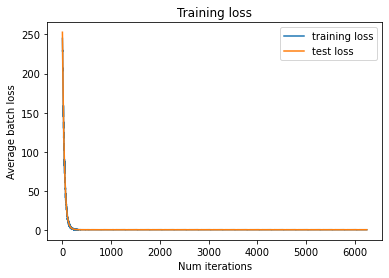

In [10]:
# Plot loss: 
fig = plt.figure()
plt.title('Training loss')
plt.xlabel('Num iterations')
plt.ylabel('Average batch loss')
plt.plot(avg_loss, label = 'training loss')
plt.plot(avg_loss_test, label = 'test loss')
plt.legend()
fig.savefig('Loss_project_2.jpg')
plt.show()